# Time Series Forecasting Youtube Tutorial
## Using Machine Learning to Forecast Energy Consumption

This notebook is accompanied by a Youtube tutorial.

[WATCH THE VIDEO HERE](https://youtu.be/vV12dGe_Fho)

[You can find it on my channel here!](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw)

![](https://res.cloudinary.com/monday-blogs/w_768,h_384,c_fit/fl_lossy,f_auto,q_auto/wp-blog/2021/05/sales-forecasting-software.jpg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
print('Importados')

Importados


## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


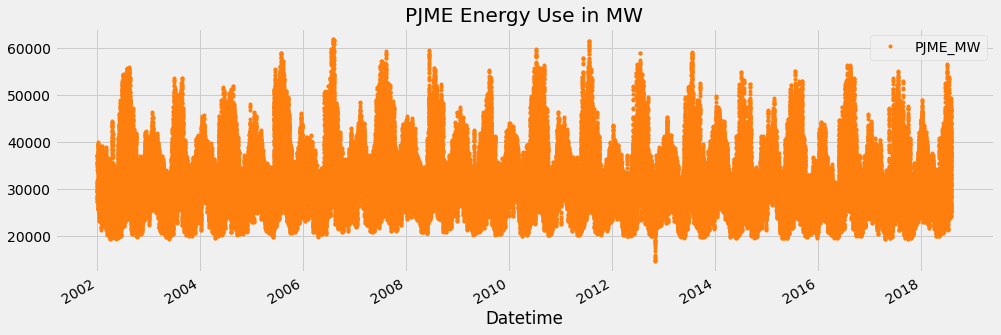

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PJME Energy Use in MW')
plt.show()

# Train / Test Split

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

In [6]:
train.head()
test.head()

,PJME_MW
Datetime,
2015-01-01 00:00:00,32802.0
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0


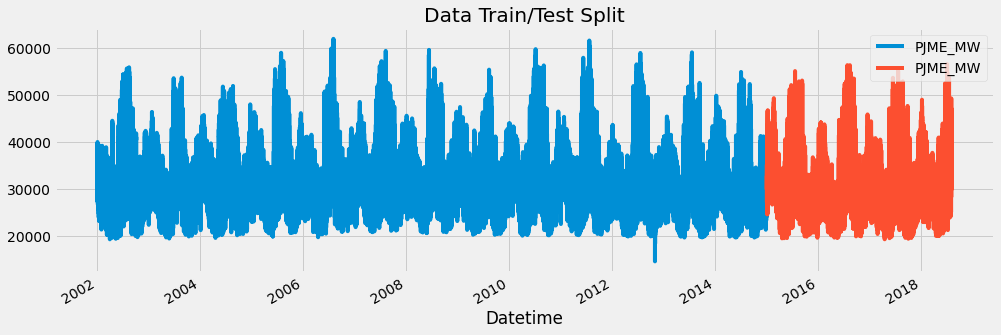

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
plt.show()

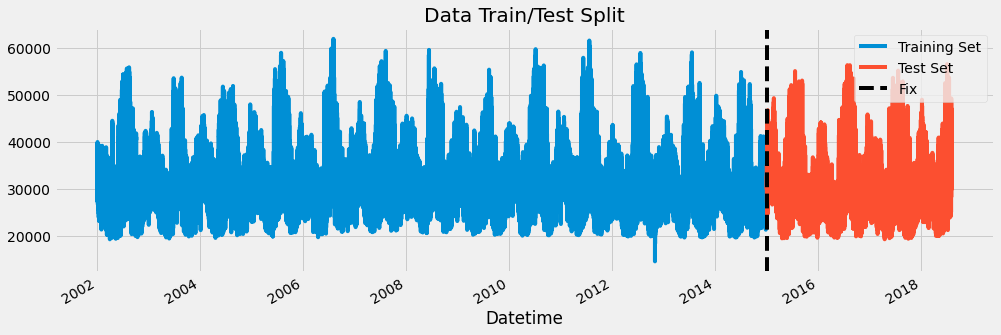

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set','Fix'])
plt.show()

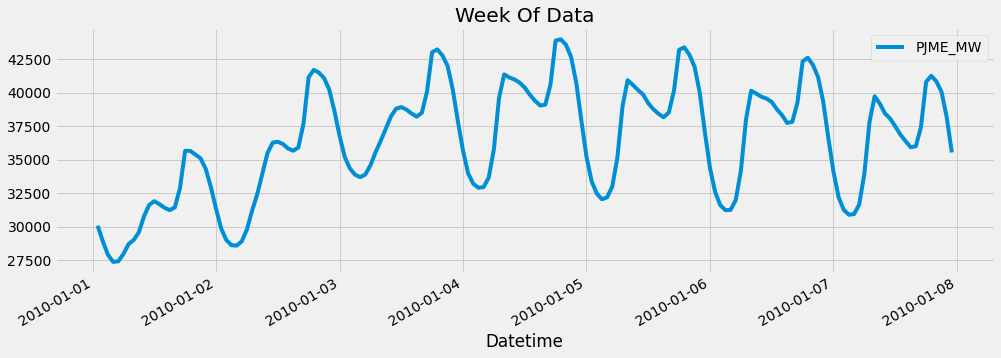

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [11]:
df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


# Visualize our Feature / Target Relationship

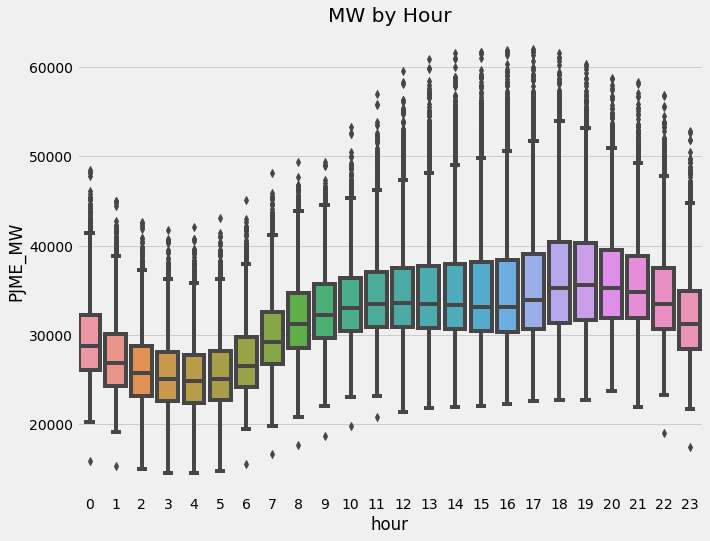

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

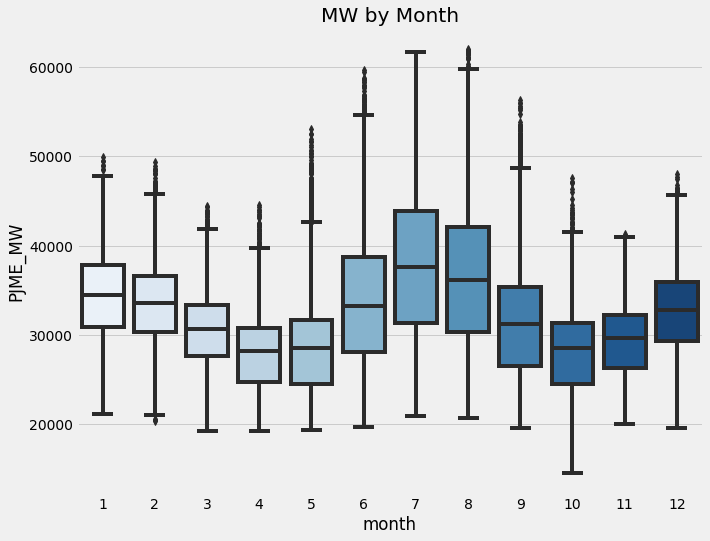

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

In [15]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
X_train.head()

,dayofyear,hour,dayofweek,quarter,month,year
Datetime,,,,,,
2002-12-31 01:00:00,365,1,1,4,12,2002
2002-12-31 02:00:00,365,2,1,4,12,2002
2002-12-31 03:00:00,365,3,1,4,12,2002
2002-12-31 04:00:00,365,4,1,4,12,2002
2002-12-31 05:00:00,365,5,1,4,12,2002


El código muestra el entrenamiento de un modelo de regresión utilizando la librería XGBoost (eXtreme Gradient Boosting).

Los parámetros del modelo se pasan al constructor de la clase XGBRegressor. Estos parámetros son:

* base_score: es el valor inicial que se asigna a los pesos de cada observación. Por defecto es 0.5.
* booster: especifica el tipo de modelo que se usará para realizar la predicción. Los valores posibles son 'gbtree' (árbol de decisiones) o 'gblinear' (regresión lineal). En este caso se está utilizando un árbol de decisiones.
* n_estimators: es el número de árboles de decisión que se entrenarán en el modelo. En este caso se están entrenando 1000 árboles.
* early_stopping_rounds: especifica después de cuántas iteraciones sin mejora en el error de validación se detendrá el entrenamiento. En este caso se detendrá después de 50 iteraciones sin mejora.
* objective: especifica la función de pérdida que se quiere minimizar. En este caso se está utilizando la función de pérdida 'reg:linear' para una regresión lineal.
* max_depth: es la profundidad máxima de cada árbol de decisión. En este caso se está utilizando una profundidad máxima de 3 niveles.
* learning_rate: es la tasa de aprendizaje que se utilizará durante el entrenamiento. En este caso se está utilizando una tasa de aprendizaje de 0.01.

Posteriormente, se entrena el modelo con el método fit utilizando los datos de entrenamiento X_train y y_train. Además, se especifica un conjunto de evaluación con el parámetro eval_set, que incluye tanto los datos de entrenamiento como los datos de prueba. El parámetro verbose indica la cantidad de información que se imprimirá durante el entrenamiento, en este caso se está imprimiendo información cada 100 iteraciones.

In [17]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[01:34:31] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21576	validation_1-rmse:11743.75117
[200]	validation_0-rmse:5835.12473	validation_1-rmse:5365.67712
[300]	validation_0-rmse:3915.75572	validation_1-rmse:4020.67027
[400]	validation_0-rmse:3443.16487	validation_1-rmse:3853.40425
[500]	validation_0-rmse:3285.33827	validation_1-rmse:3805.30193
[600]	validation_0-rmse:3201.92939	validation_1-rmse:3772.44905
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91088
[800]	validation_0-rmse:3109.24250	validation_1-rmse:3733.89694
[900]	validation_0-rmse:3079.40078	validation_1-rmse:3725.61208
[999]	validation_0-rmse:3052.73502	validation_1-rmse:3722.92243


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

# Feature Importance

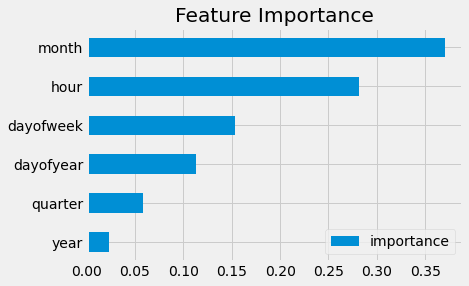

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [19]:
test['prediction'] = reg.predict(X_test)

In [20]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1,30527.792969
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53,28238.072266
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53,27310.228516
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53,26884.867188
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53,26884.867188


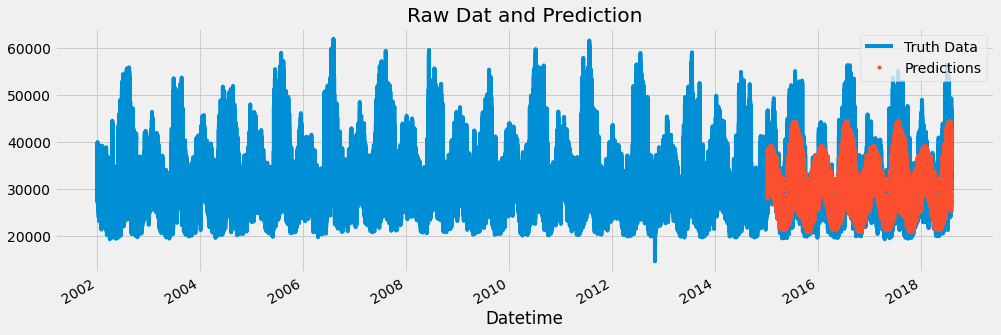

In [21]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

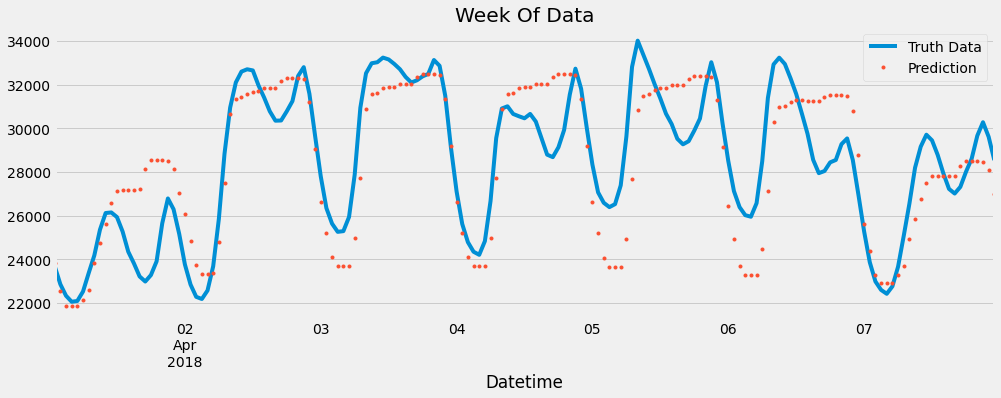

In [22]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [23]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75


# Calculate Error
- Look at the worst and best predicted days

In [24]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [25]:
test['date'] = test.index.date

In [26]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,error,date
Datetime,,,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1,30527.792969,2274.207031,2015-01-01
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53,28238.072266,3933.072266,2015-12-31
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53,27310.228516,4154.228516,2015-12-31
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53,26884.867188,4370.867188,2015-12-31
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53,26884.867188,4554.867188,2015-12-31


In [27]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12839.595459
2016-08-14    12780.209554
2016-09-10    11356.302002
2015-02-20    10965.976237
2016-09-09    10864.953451
2018-01-06    10506.844889
2016-08-12    10124.050618
2015-02-21     9881.798503
2015-02-16     9781.549805
2018-01-07     9739.143555
Name: error, dtype: float64

# Next Steps
- More robust cross validation
- Add more features (weather forecast, holidays)

# The End